In [1]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import pickle
import string

/home/ebrahim/brainaudio/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [45]:
# Available models - uncomment the one you want to use
# MODEL_ID = "google/gemma-3-270m"
MODEL_ID = "google/gemma-3-4b-pt"
#MODEL_ID = "HuggingFaceTB/SmolLM2-135M"

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
print(f"Loaded tokenizer: {MODEL_ID}")

Loaded tokenizer: google/gemma-3-4b-pt


In [46]:
# Load training and validation transcripts
with open("/data2/brain2text/b2t_25/transcripts_train.pkl", "rb") as f:
    transcripts_train = pickle.load(f)

with open("/data2/brain2text/b2t_25/transcripts_val.pkl", "rb") as f:
    transcripts_val = pickle.load(f)

print(f"Training transcripts: {len(transcripts_train)}")
print(f"Validation transcripts: {len(transcripts_val)}")
print(f"\nSample training transcript: {transcripts_train[0] if transcripts_train else 'N/A'}")
print(f"Sample validation transcript: {transcripts_val[0] if transcripts_val else 'N/A'}")

Training transcripts: 8072
Validation transcripts: 1426

Sample training transcript: ['Bring it closer.']
Sample validation transcript: ['You can see the code at this point as well.']


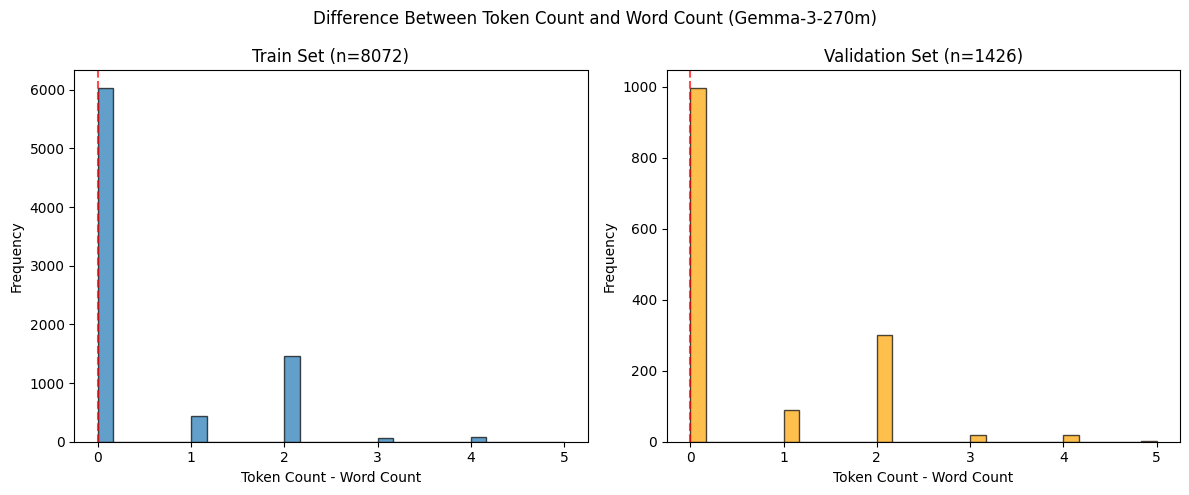

Train - Mean diff: 0.48, Min: 0, Max: 5
Val   - Mean diff: 0.58, Min: 0, Max: 5


In [47]:
import string
import matplotlib.pyplot as plt

def compute_token_word_diff(nested_sentences, tokenizer):
    """
    Computes the difference (tokens - words) for each sentence.
    Returns a list of differences.
    """
    differences = []
    
    for entry in nested_sentences:
        raw_text = entry[0]
        stripped_text = raw_text.rstrip(string.punctuation)
        
        token_ids = tokenizer.encode(stripped_text, add_special_tokens=False)
        
        word_count = len(stripped_text.split())
        token_count = len(token_ids)
        
        differences.append(token_count - word_count)
    
    return differences

# Compute differences for train and validation sets
train_diffs = compute_token_word_diff(transcripts_train, tokenizer)
val_diffs = compute_token_word_diff(transcripts_val, tokenizer)

# Plot histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(train_diffs, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Token Count - Word Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Train Set (n={len(train_diffs)})')
axes[0].axvline(x=0, color='red', linestyle='--', alpha=0.7)

axes[1].hist(val_diffs, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Token Count - Word Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Validation Set (n={len(val_diffs)})')
axes[1].axvline(x=0, color='red', linestyle='--', alpha=0.7)

plt.suptitle('Difference Between Token Count and Word Count (Gemma-3-270m)')
plt.tight_layout()
plt.show()

print(f"Train - Mean diff: {sum(train_diffs)/len(train_diffs):.2f}, Min: {min(train_diffs)}, Max: {max(train_diffs)}")
print(f"Val   - Mean diff: {sum(val_diffs)/len(val_diffs):.2f}, Min: {min(val_diffs)}, Max: {max(val_diffs)}")

Loading tokenizer: google/gemma-3-4b-pt...
Reading vocabulary from /data2/brain2text/lm/vocab_lower_100k.txt...
Loaded 95853 clean words.
Analyzing tokens...


100%|██████████| 95853/95853 [00:01<00:00, 57639.57it/s]



Saving 13454 atomic words to safe_atomic_words.txt...
Saving 49307 non-atomic words to safe_nonatomic_words.txt...
Saving 57865 heavy words to heavy_multi_token_words.txt...
Histogram saved to casing_token_diff_histogram.png

=== ANALYSIS SUMMARY ===
Total Clean Words: 95853
----------------------------------------
SAFE WORDS (Diff = 0):        62761 (65.5%)
   -> Atomic (1 token):       13454 (Saved to safe_atomic_words.txt)
   -> Multi-token (n tokens): 49307 (Saved to safe_nonatomic_words.txt)
----------------------------------------
RISKY WORDS (Diff != 0):      33092 (34.5%)
----------------------------------------
HEAVY WORDS (>1 token in BOTH cases): 57865 (Saved to heavy_multi_token_words.txt)


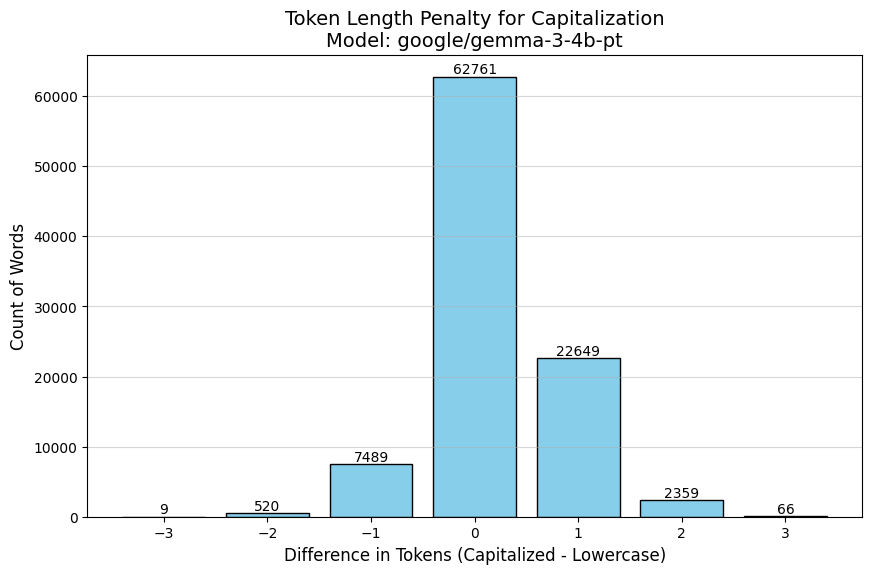

In [40]:
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from tqdm import tqdm
import collections
import string

# ==========================================
# CONFIGURATION
# ==========================================
MODEL_NAME = "google/gemma-3-4b-pt" 
VOCAB_FILE = "/data2/brain2text/lm/vocab_lower_100k.txt"

# Output files
FILE_ATOMIC = "safe_atomic_words.txt"       # Diff=0, 1 token
FILE_NONATOMIC = "safe_nonatomic_words.txt" # Diff=0, >1 token
FILE_HEAVY = "heavy_multi_token_words.txt"  # >1 token in BOTH cases

def analyze_and_save_safe_words():
    print(f"Loading tokenizer: {MODEL_NAME}...")
    try:
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    except Exception as e:
        print(f"Error: {e}")
        print("Note: You may need to run 'huggingface-cli login' for Gemma models.")
        return

    print(f"Reading vocabulary from {VOCAB_FILE}...")
    words = []
    skipped_count = 0
    invalid_chars = set(string.punctuation)

    try:
        with open(VOCAB_FILE, "r", encoding="utf-8") as f:
            for line in f:
                w = line.strip()
                if not w: continue
                
                # Filter punctuation
                if any(char in invalid_chars for char in w):
                    skipped_count += 1
                    continue
                
                words.append(w)
                
    except FileNotFoundError:
        print("File not found! Please check the path.")
        return

    print(f"Loaded {len(words)} clean words.")
    
    # LISTS TO SAVE
    safe_atomic_list = []      
    safe_nonatomic_list = []   
    heavy_words_list = []      # New list for "Heavy" words
    
    diff_counts = []
    examples = collections.defaultdict(list)

    print("Analyzing tokens...")
    for word in tqdm(words):
        # Simulate mid-sentence appearance
        tok_lower = tokenizer.encode(" " + word.lower(), add_special_tokens=False)
        tok_cap   = tokenizer.encode(" " + word.capitalize(), add_special_tokens=False)
        
        len_l = len(tok_lower)
        len_c = len(tok_cap)
        diff = len_c - len_l
        
        diff_counts.append(diff)
        
        # 1. Categorize SAFE words (Diff = 0)
        if diff == 0:
            if len_l == 1:
                safe_atomic_list.append(word)
            else:
                safe_nonatomic_list.append(word)
        
        # 2. Categorize HEAVY words (>1 token in BOTH cases)
        if len_l > 1 and len_c > 1:
            heavy_words_list.append(word)

        # 3. Collect Diff Examples for plot/print
        if len(examples[diff]) < 5:
            examples[diff].append(f"{word} (Cap:{len_c} vs Low:{len_l})")

    # ==========================================
    # SAVING TO FILES
    # ==========================================
    print(f"\nSaving {len(safe_atomic_list)} atomic words to {FILE_ATOMIC}...")
    with open(FILE_ATOMIC, "w", encoding="utf-8") as f:
        for w in sorted(safe_atomic_list):
            f.write(w + "\n")
            
    print(f"Saving {len(safe_nonatomic_list)} non-atomic words to {FILE_NONATOMIC}...")
    with open(FILE_NONATOMIC, "w", encoding="utf-8") as f:
        for w in sorted(safe_nonatomic_list):
            f.write(w + "\n")

    print(f"Saving {len(heavy_words_list)} heavy words to {FILE_HEAVY}...")
    with open(FILE_HEAVY, "w", encoding="utf-8") as f:
        for w in sorted(heavy_words_list):
            f.write(w + "\n")

    # ==========================================
    # PLOTTING
    # ==========================================
    plt.figure(figsize=(10, 6))
    if diff_counts:
        bins = range(min(diff_counts), max(diff_counts) + 2)
        counts, _, _ = plt.hist(diff_counts, bins=bins, align='left', rwidth=0.8, color='skyblue', edgecolor='black')
        
        plt.title(f"Token Length Penalty for Capitalization\nModel: {MODEL_NAME}", fontsize=14)
        plt.xlabel("Difference in Tokens (Capitalized - Lowercase)", fontsize=12)
        plt.ylabel("Count of Words", fontsize=12)
        plt.xticks(list(set(diff_counts)))
        plt.grid(axis='y', alpha=0.5)
        
        for i, count in enumerate(counts):
            if count > 0:
                plt.text(bins[i], count, str(int(count)), ha='center', va='bottom')

    output_img = "casing_token_diff_histogram.png"
    plt.savefig(output_img)
    print(f"Histogram saved to {output_img}")
    
    # ==========================================
    # PRINT SUMMARY
    # ==========================================
    total = len(diff_counts)
    same_len = diff_counts.count(0)
    longer = total - same_len
    
    print("\n=== ANALYSIS SUMMARY ===")
    print(f"Total Clean Words: {total}")
    print("-" * 40)
    print(f"SAFE WORDS (Diff = 0):        {same_len} ({same_len/total:.1%})")
    print(f"   -> Atomic (1 token):       {len(safe_atomic_list)} (Saved to {FILE_ATOMIC})")
    print(f"   -> Multi-token (n tokens): {len(safe_nonatomic_list)} (Saved to {FILE_NONATOMIC})")
    print("-" * 40)
    print(f"RISKY WORDS (Diff != 0):      {longer} ({longer/total:.1%})")
    print("-" * 40)
    print(f"HEAVY WORDS (>1 token in BOTH cases): {len(heavy_words_list)} (Saved to {FILE_HEAVY})")

if __name__ == "__main__":
    analyze_and_save_safe_words()

In [44]:
from transformers import AutoTokenizer
import torch

def get_llama_tokens(word_list, model_id="google/gemma-3-270m", add_leading_space=True):
    """
    Tokenizes a list of words using the specific Llama 3 tokenizer.
    
    Args:
        word_list (list): List of strings to tokenize.
        model_id (str): The Hugging Face model ID.
        add_leading_space (bool): If True, prepends a space to each word 
                                  (simulates the word appearing mid-sentence).
                                  
    Returns:
        dict: A dictionary mapping words to their token IDs and string representations.
    """
    print(f"Loading tokenizer: {model_id}...")
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_id)
    except OSError:
        print(f"Error: You probably need to run 'huggingface-cli login' or request access to {model_id}.")
        return None

    results = {}

    print(f"Processing {len(word_list)} words...")
    
    for word in word_list:
        # Llama 3 is sensitive to spaces. 
        # "apple" -> IDs for start of sentence
        # " apple" -> IDs for mid-sentence (usually what you want)
        text_to_process = " " + word if add_leading_space else word
        
        # tokenize(..., add_special_tokens=False) prevents adding <|begin_of_text|>
        tokens = tokenizer.encode(text_to_process, add_special_tokens=False)
        
        # For debugging: see what the tokens actually look like decoded back
        # (Llama 3 uses a byte-level BPE, so individual tokens might look like fragments)
        decoded_fragments = [tokenizer.decode([t]) for t in tokens]
        
        results[word] = {
            "input_text": text_to_process,
            "token_ids": tokens,
            "count": len(tokens),
            "fragments": decoded_fragments
        }

    return results

# ==========================================
# Example Usage
# ==========================================
if __name__ == "__main__":
    # Test with some casing variants and compound words
    words_to_test = [
        "afghanistan", "Afghanistan", 
        "themselves", "Themselves",
        "royal", "Royal", 
        "aerobics", "Aerobics",
        "alaska", "Alaska", 
        "mccain", "McCain", 
        "twitter", "Twitter", 
        "turnip", "Turnip"
    ]
    
    # 1. Run tokenizer
    token_data = get_llama_tokens(words_to_test)
    
    if token_data:
        # 2. Print pretty results
        print(f"\n{'WORD':<15} | {'IDS':<20} | {'FRAGMENTS'}")
        print("-" * 60)
        for word, data in token_data.items():
            ids_str = str(data['token_ids'])
            frags = str(data['fragments'])
            print(f"{word:<15} | {ids_str:<20} | {frags}")

Loading tokenizer: google/gemma-3-270m...
Processing 16 words...

WORD            | IDS                  | FRAGMENTS
------------------------------------------------------------
afghanistan     | [4549, 17008, 9010]  | [' af', 'ghan', 'istan']
Afghanistan     | [27098]              | [' Afghanistan']
themselves      | [5507]               | [' themselves']
Themselves      | [669, 182462]        | [' The', 'mselves']
royal           | [19833]              | [' royal']
Royal           | [12194]              | [' Royal']
aerobics        | [232662]             | [' aerobics']
Aerobics        | [35874, 982, 1229]   | [' Aer', 'ob', 'ics']
alaska          | [610, 18477]         | [' al', 'aska']
Alaska          | [32130]              | [' Alaska']
mccain          | [227387, 662]        | [' mcc', 'ain']
McCain          | [99212]              | [' McCain']
twitter         | [27664]              | [' twitter']
Twitter         | [9526]               | [' Twitter']
turnip          | [2490, 760] 